<a href="https://colab.research.google.com/github/SalhaAlzahrani/SkinLiTE/blob/main/_Skin_SupConLearn_3ClassLesions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🟪 Skin Lesion images for classification with Supervised Contrastive Learning, Classes: Melanoma, Nevus, Seborrheic_Keratosis



## Introduction

Supervised Contrastive Learning (Prannay Khosla et al.) is a training methodology that outperforms supervised training with crossentropy on classification tasks.


Essentially, training an image classification model with Supervised Contrastive Learning is performed in two phases:

- Training an encoder to learn to produce vector representations of input images such that representations of images in the same class will be more similar compared to representations of images in different classes.
- Training a classifier on top of the frozen encoder.

In [ ]:
!pip install -U -q tensorflow-addons
!pip install nest_asyncio
!pip install keras-cv

In [ ]:
from keras.src.applications import imagenet_utils

import tensorflow as tf
from tensorflow import keras
from keras import layers
import tensorflow_addons as tfa
from keras.preprocessing import image_dataset_from_directory
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow_hub as hub
import tensorflow_datasets as tfds
import pathlib
import glob
import keras_cv
import os
from sklearn.utils.class_weight import compute_class_weight
from sklearn.utils import class_weight

from google.colab import drive
# Define the path to the MRI data directory
drive.mount('/content/drive', force_remount=True)

import nest_asyncio

Using TensorFlow backend
Mounted at /content/drive


# 🟣 Plot functions

In [ ]:
def plot_training_curves(history, title):
    loss = np.array(history.history['loss'])
    val_loss = np.array(history.history['val_loss'])
    epochs = range(len(history.history['loss']))
    accuracy = np.array(history.history['accuracy'])
    val_accuracy = np.array(history.history['val_accuracy'])

    plt.style.use('seaborn') #ggplot #bmh
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 2.5))
    fig.patch.set_facecolor('xkcd:white')

    # Plot loss
    ax1.plot(epochs, loss, label='training_loss', marker='.', )
    ax1.plot(epochs, val_loss, label='val_loss', marker='.', )
    ax1.fill_between(epochs, loss, val_loss, where=(loss > val_loss), color='C0', alpha=0.3, interpolate=True)
    ax1.fill_between(epochs, loss, val_loss, where=(loss < val_loss), color='C1', alpha=0.3, interpolate=True)
    ax1.set_title('Loss: '+title, fontsize=10)
    ax1.set_xlabel('Epochs', fontsize=10)
    ax1.legend(fontsize=8)

    # Plot accuracy
    ax2.set_ylim(ymin=0, ymax=1.1)
    ax2.plot(epochs, accuracy, label='training_accuracy', marker='.')
    ax2.plot(epochs, val_accuracy, label='val_accuracy', marker='.')
    ax2.fill_between(epochs, accuracy, val_accuracy, where=(accuracy > val_accuracy), color='C0', alpha=0.3, interpolate=True)
    ax2.fill_between(epochs, accuracy, val_accuracy, where=(accuracy < val_accuracy), color='C1', alpha=0.3, interpolate=True)
    ax2.set_title('Accuracy: '+title, fontsize=10)
    ax2.set_xlabel('Epochs', fontsize=10)
    ax2.legend(fontsize=10)

In [ ]:
def visualize_dataset(dataset, title):
  plt.figure(figsize=(10, 10)).suptitle(title, fontsize=18)
  for images, labels in iter(dataset.take(9)):
    for i in range(9):
      ax = plt.subplot(3, 3, i + 1)
      img = tf.image.rgb_to_grayscale(images[i])
      plt.imshow(img, cmap='gist_gray')
      ax.grid()
      plt.axis("off")

# 🟣 Hyperparameters


In [ ]:
IMG_SIZE = 256 # We'll resize input images to this size.
input_shape = (256, 256, 3)
learning_rate = 0.001
weight_decay = 0.0001
num_epochs = 100

batch_size = 265
hidden_units = 512
projection_units = 128
dropout_rate = 0.5
temperature = 0.05

# 🟣 Dataset

In [ ]:
path = '/content/drive/MyDrive/_MyResearch_/Skin_Disease_Datasets/skin-lesions/'
# train data
train_ds = image_dataset_from_directory(
    directory= path ,
    labels='inferred',
    label_mode='int',
    batch_size=32,
    image_size=(IMG_SIZE,IMG_SIZE),
    color_mode='rgb',
    shuffle=True,
    seed=1000,
    validation_split=0.2,
    subset='training',
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False,
)
# validation data
val_ds = image_dataset_from_directory(
    directory=path ,
    labels='inferred',
    label_mode='int',
    batch_size=32,
    image_size=(IMG_SIZE,IMG_SIZE),
    color_mode='rgb',
    shuffle=True,
    seed=1000,
    validation_split=0.2,
    subset='validation',
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False,
)
#Configure the dataset for performance
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)

Found 2750 files belonging to 3 classes.
Using 2200 files for training.
Found 2750 files belonging to 3 classes.
Using 550 files for validation.


In [ ]:
train_ds_ = image_dataset_from_directory(
    directory= path ,
    labels='inferred',
    label_mode='categorical',
    batch_size=32,
    image_size=(IMG_SIZE,IMG_SIZE),
)
class_names = train_ds_.class_names
print(class_names)
##################
NUM_CLASSES = len(class_names)
##################
num_images_per_class = []
for label in class_names:
    dir_name = path + label
    num_images_per_class.append(len([name for name in os.listdir(dir_name)]))
# y_train=list of train labels wrt to given directory format
y_train=[]
for i in range(0, len(num_images_per_class)):
    y_train+=[i]*num_images_per_class[i]
classes = list()
for i in range(NUM_CLASSES): classes.append(i)
class_weights = compute_class_weight(class_weight="balanced", classes=classes, y=np.asarray(y_train))
class_weights_dict = {}
for i in range(len(class_weights)):
   class_weights_dict[i] = class_weights[i]
class_weights_dict

Found 2750 files belonging to 3 classes.
['melanoma', 'nevus', 'seborrheic_keratosis']


{0: 1.7594369801663468, 1: 0.49737746427925483, 2: 2.3747841105354057}

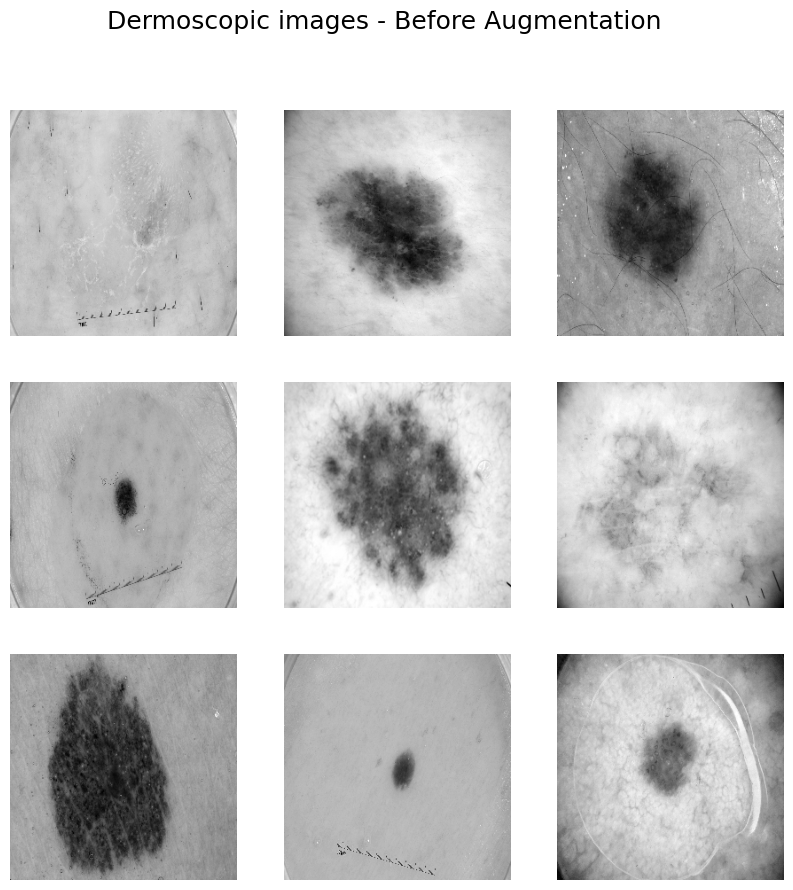

In [ ]:
visualize_dataset(train_ds, title="Dermoscopic images - Before Augmentation")

# 🅰 Data augmentation



In [ ]:
def to_dict(image, label):
    image = tf.cast(image, tf.float32)
    label = tf.one_hot(label, NUM_CLASSES)
    return {"images": image, "labels": label}

def preprocess_for_model(inputs):
    images, labels = inputs["images"], inputs["labels"]
    images = tf.cast(images, tf.float32)
    return images, labels

randaug = keras_cv.layers.RandAugment(value_range=(0, 255), augmentations_per_image=3, magnitude=0.5)
augmix = keras_cv.layers.AugMix([0, 255])
mixup = keras_cv.layers.MixUp()
cutmix = keras_cv.layers.CutMix()

#No augmentation
train_ds_v = train_ds.map(to_dict)
train_ds_v = train_ds_v.map(preprocess_for_model, num_parallel_calls=AUTOTUNE)
train_ds_v = train_ds_v.prefetch(AUTOTUNE)
val_ds_v = val_ds.map(to_dict)
val_ds_v = val_ds_v.map(preprocess_for_model, num_parallel_calls=AUTOTUNE)
val_ds_v = val_ds_v.prefetch(AUTOTUNE) #Use this for fit

def aug_pipeline1(samples):
    samples = randaug(samples, training=True)
    return samples
def aug_pipeline2(samples):
    samples = augmix(samples, training=True)
    return samples
def aug_pipeline3(samples):
    samples = mixup(samples, training=True)
    return samples
def aug_pipeline4(samples):
    samples = cutmix(samples, training=True)
    return samples
#RandAug
randaug_ds = train_ds.shuffle(1000).map(to_dict)
randaug_ds = randaug_ds.map(aug_pipeline1)
randaug_ds = randaug_ds.map(preprocess_for_model, num_parallel_calls=AUTOTUNE)
randaug_ds = randaug_ds.prefetch(AUTOTUNE) #Use this for fit

#AugMix
augmix_ds = train_ds.shuffle(1000).map(to_dict)
augmix_ds = augmix_ds.map(aug_pipeline2)
augmix_ds = augmix_ds.map(preprocess_for_model, num_parallel_calls=AUTOTUNE)
augmix_ds = augmix_ds.prefetch(AUTOTUNE) #Use this for fit

#MixUp
mixup_ds = train_ds.shuffle(1000).map(to_dict)
mixup_ds = mixup_ds.map(aug_pipeline3)
mixup_ds = mixup_ds.map(preprocess_for_model, num_parallel_calls=AUTOTUNE)
mixup_ds = mixup_ds.prefetch(AUTOTUNE) #Use this for fit

#CutMix
cutmix_ds = train_ds.shuffle(1000).map(to_dict)
cutmix_ds = cutmix_ds.map(aug_pipeline4)
cutmix_ds = cutmix_ds.map(preprocess_for_model, num_parallel_calls=AUTOTUNE)
cutmix_ds = cutmix_ds.prefetch(AUTOTUNE) #Use this for fit

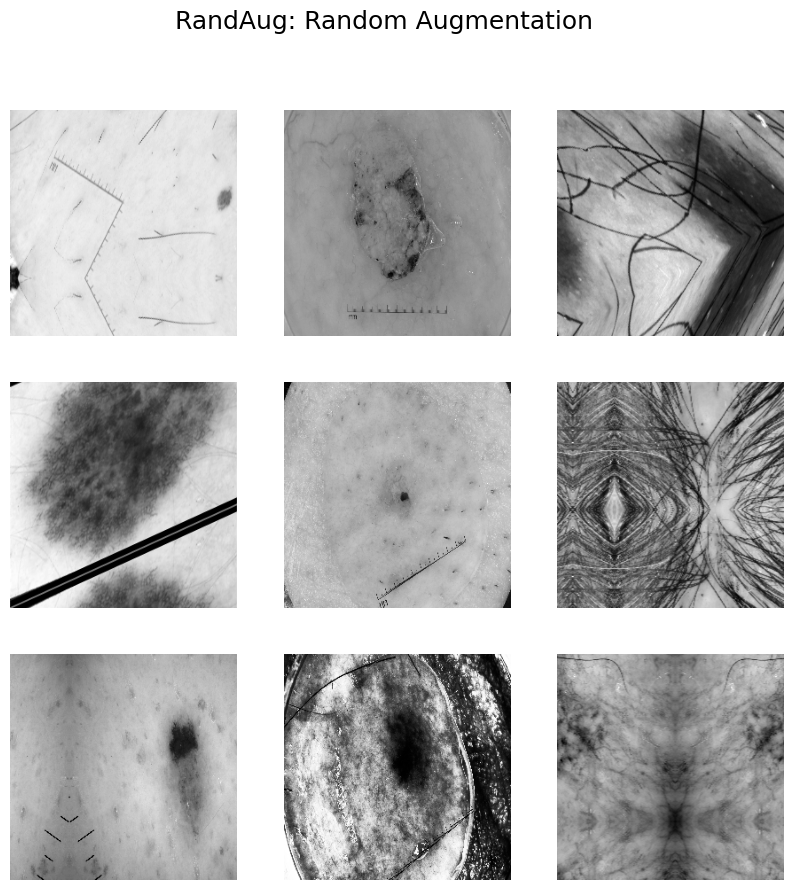

In [ ]:
visualize_dataset(randaug_ds, title="RandAug: Random Augmentation")

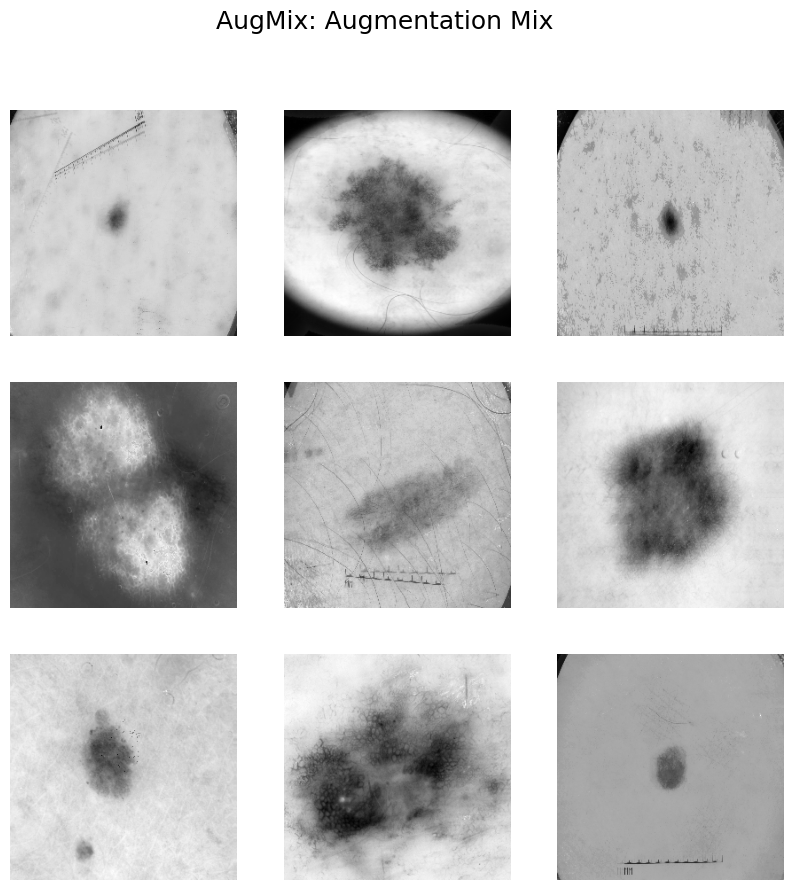

In [ ]:
visualize_dataset(augmix_ds, title="AugMix: Augmentation Mix")

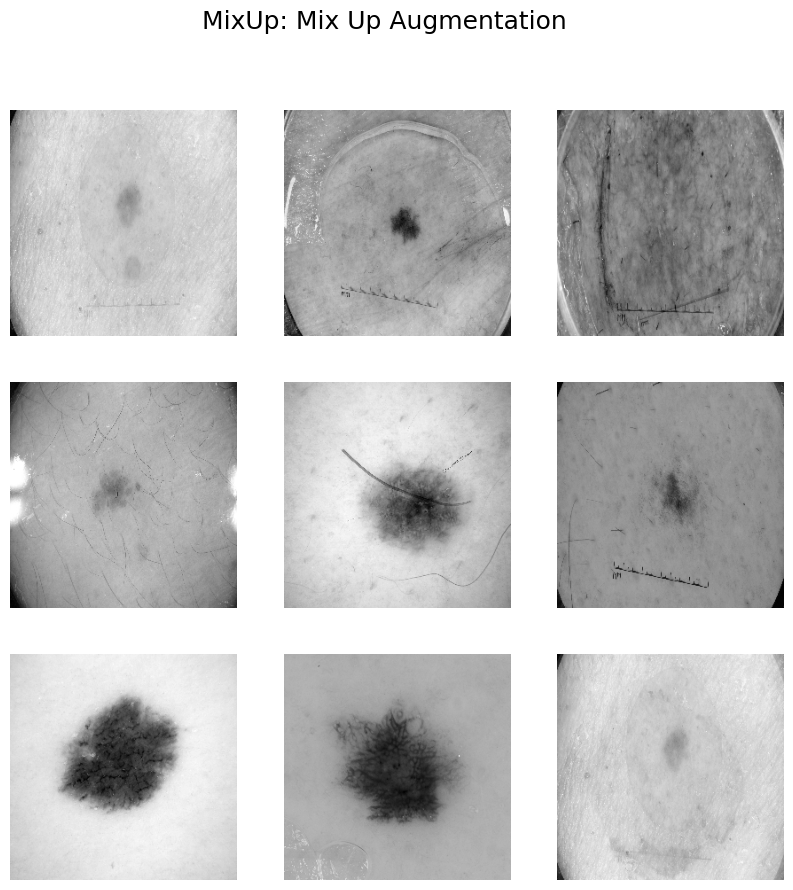

In [ ]:
visualize_dataset(mixup_ds, title="MixUp: Mix Up Augmentation")

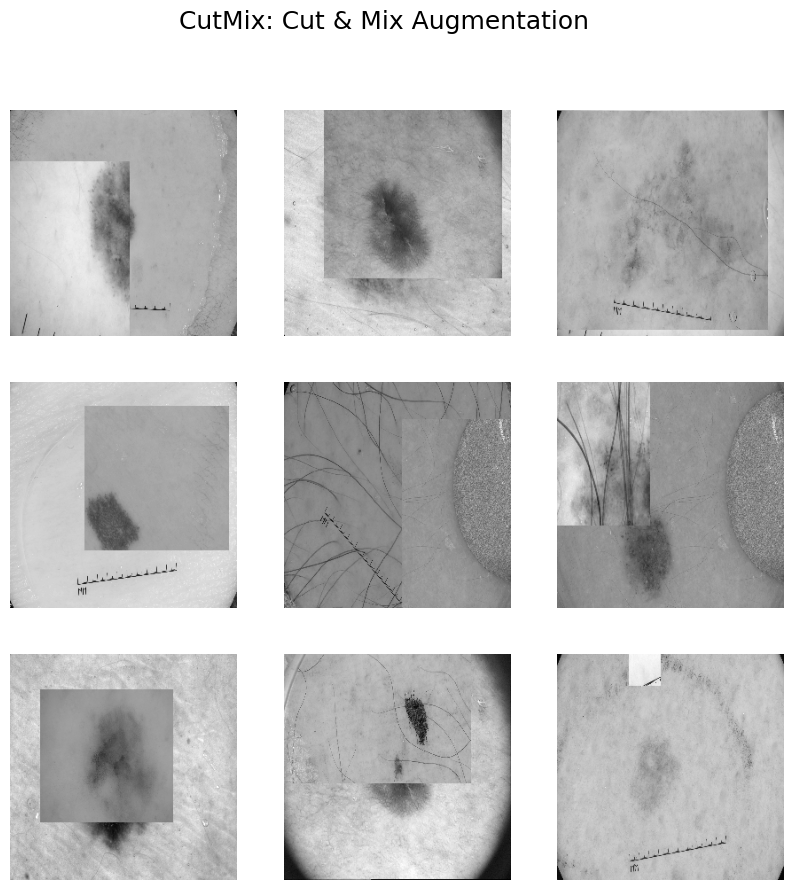

In [ ]:
visualize_dataset(cutmix_ds, title="CutMix: Cut & Mix Augmentation")

# 🟣 Experiment


In [ ]:
def run_experiment(training_dataset, validation_dataset, model):
    # Create Adam optimizer with weight decay.
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay,
    )
    # Compile the model.
    model.compile(
        optimizer=optimizer,
        loss=keras.losses.CategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.CategoricalAccuracy(name="accuracy"),
            keras.metrics.AUC(name='AUC'),
            keras.metrics.Precision(name='Precision'),
            keras.metrics.Recall(name='Recall'),
            keras.metrics.F1Score(name='F1 score'),
        ],
    )
    # Create a learning rate scheduler callback.
    reduce_lr = keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=5
    )
    # Create an early stopping callback.
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=10, restore_best_weights=True
    )
    # Fit the model.
    history = model.fit(
        training_dataset,
        validation_data = validation_dataset,
        batch_size=batch_size,
        epochs=num_epochs,
        class_weight=class_weights_dict,
        callbacks=[early_stopping, reduce_lr],
    )
    # Return history to plot learning curves.
    return history

## create_encoder
The encoder model takes the image as input and turns it into a 2048-dimensional feature vector.

In [ ]:
def create_encoder():
    resnet = keras.applications.ResNet50V2(
        include_top=False, weights=None, input_shape=input_shape, pooling="avg"
    )
    inputs = keras.Input(shape=input_shape)
    outputs = resnet(inputs)
    model = keras.Model(inputs=inputs, outputs=outputs, name="SkinLiTE-encoder")
    return model
encoder = create_encoder()

## create_classifier
The classification model adds a fully-connected layer on top of the encoder, plus a softmax layer with the target classes.

In [ ]:
def create_classifier(encoder, trainable=True):
    for layer in encoder.layers:
        layer.trainable = trainable
    inputs = keras.Input(shape=input_shape)
    features = encoder(inputs)
    features = layers.Dropout(dropout_rate)(features)
    features = layers.Dense(hidden_units, activation="relu")(features)
    features = layers.Dropout(dropout_rate)(features)
    outputs = layers.Dense(NUM_CLASSES)(features)
    model = keras.Model(inputs=inputs, outputs=outputs, name="SkinLiTE-classifier")
    return model

## SupervisedContrastiveLoss
- Pase 1: The model is trained in two phases. In the first phase, the encoder is pretrained to optimize the supervised contrastive loss, described in Prannay Khosla et al..
- Phas 2: The classifier is trained using the trained encoder with its weights freezed; only the weights of fully-connected layers with the softmax are optimized.

In [ ]:
class SupervisedContrastiveLoss(keras.losses.Loss):
    def __init__(self, temperature=1, name=None):
        super().__init__(name=name)
        self.temperature = temperature

    def __call__(self, labels, feature_vectors, sample_weight=None):
        # Normalize feature vectors
        feature_vectors_normalized = tf.math.l2_normalize(feature_vectors, axis=1)
        # Compute logits
        logits = tf.divide(
            tf.matmul(
                feature_vectors_normalized, tf.transpose(feature_vectors_normalized)
            ),
            self.temperature,
        )
        decoded = tf.argmax(labels, axis=1)
        return tfa.losses.npairs_loss(tf.squeeze(decoded), logits)

def add_projection_head(encoder):
    inputs = keras.Input(shape=input_shape)
    features = encoder(inputs)
    outputs = layers.Dense(projection_units, activation="relu")(features)
    model = keras.Model(
        inputs=inputs, outputs=outputs, name="SkinLiTE-encoder_with_projection-head"
    )
    return model



---



# 🟣 NoAug


## Experiment 1: Baseline Classifier


In [ ]:
encoder = create_encoder()
classifier = create_classifier(encoder)
history_SL_noaug = run_experiment(train_ds_v, val_ds_v, classifier)

Epoch 1/100
69/69 [==============================] - 283s 3s/step - loss: 1.4431 - accuracy: 0.3677 - AUC: 0.5434 - Precision: 0.4026 - Recall: 0.2086 - F1 score: 0.3324 - val_loss: 45938.7422 - val_accuracy: 0.6691 - val_AUC: 0.7518 - val_Precision: 0.6691 - val_Recall: 0.6691 - val_F1 score: 0.2672 - lr: 0.0010
Epoch 2/100
69/69 [==============================] - 63s 840ms/step - loss: 1.3238 - accuracy: 0.3555 - AUC: 0.5310 - Precision: 0.3480 - Recall: 0.1586 - F1 score: 0.3237 - val_loss: 138.9753 - val_accuracy: 0.6691 - val_AUC: 0.5223 - val_Precision: 0.3424 - val_Recall: 0.9873 - val_F1 score: 0.2672 - lr: 0.0010
Epoch 3/100
69/69 [==============================] - 62s 835ms/step - loss: 1.1741 - accuracy: 0.4145 - AUC: 0.5771 - Precision: 0.4527 - Recall: 0.2741 - F1 score: 0.3578 - val_loss: 0.9052 - val_accuracy: 0.6309 - val_AUC: 0.7116 - val_Precision: 0.5285 - val_Recall: 0.5564 - val_F1 score: 0.3484 - lr: 0.0010
Epoch 4/100
69/69 [==============================] - 62s 

<ipython-input-3-ba513de2f957>:8: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn') #ggplot #bmh


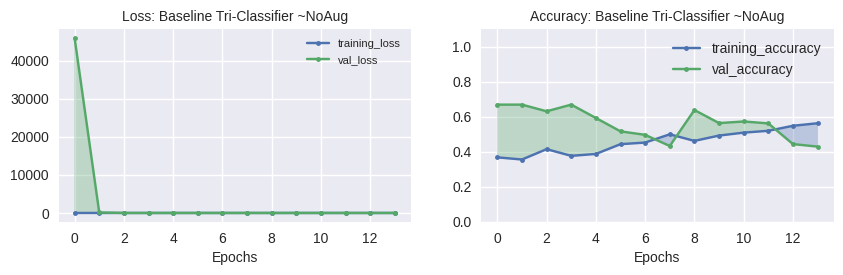

In [ ]:
plot_training_curves(history_SL_noaug, 'Baseline Tri-Classifier ~NoAug')

## Experiment 2: Supervised contrastive learning


In [ ]:
encoder = create_encoder()
encoder_with_projection_head = add_projection_head(encoder)
encoder_with_projection_head.compile(
    optimizer=keras.optimizers.Adam(learning_rate),
    loss=SupervisedContrastiveLoss(temperature),
)
history_SCL_encoder_noaug = encoder_with_projection_head.fit(
    train_ds_v, batch_size=batch_size, epochs=num_epochs
)

Epoch 1/100
69/69 [==============================] - 64s 464ms/step - loss: 3.4922
Epoch 2/100
69/69 [==============================] - 49s 639ms/step - loss: 3.4517
Epoch 3/100
69/69 [==============================] - 49s 637ms/step - loss: 3.4498
Epoch 4/100
69/69 [==============================] - 49s 640ms/step - loss: 3.4473
Epoch 5/100
69/69 [==============================] - 49s 641ms/step - loss: 3.4437
Epoch 6/100
69/69 [==============================] - 49s 644ms/step - loss: 3.4367
Epoch 7/100
69/69 [==============================] - 49s 646ms/step - loss: 3.4333
Epoch 8/100
69/69 [==============================] - 49s 642ms/step - loss: 3.4370
Epoch 9/100
69/69 [==============================] - 49s 639ms/step - loss: 3.4342
Epoch 10/100
69/69 [==============================] - 49s 642ms/step - loss: 3.4287
Epoch 11/100
69/69 [==============================] - 50s 644ms/step - loss: 3.4227
Epoch 12/100
69/69 [==============================] - 49s 643ms/step - loss: 3.4167
E

In [ ]:
classifier = create_classifier(encoder_with_projection_head, trainable=False)
history_SCL_noaug = run_experiment(train_ds_v, val_ds_v, classifier)

Epoch 1/100
69/69 [==============================] - 68s 863ms/step - loss: 4.6170 - accuracy: 0.5745 - AUC: 0.6382 - Precision: 0.4246 - Recall: 0.8245 - F1 score: 0.4908 - val_loss: 2.9641 - val_accuracy: 0.5927 - val_AUC: 0.7387 - val_Precision: 0.5289 - val_Recall: 0.7982 - val_F1 score: 0.4961 - lr: 0.0010
Epoch 2/100
69/69 [==============================] - 62s 834ms/step - loss: 3.1292 - accuracy: 0.6077 - AUC: 0.6515 - Precision: 0.4331 - Recall: 0.8132 - F1 score: 0.5236 - val_loss: 1.6251 - val_accuracy: 0.6073 - val_AUC: 0.7550 - val_Precision: 0.5408 - val_Recall: 0.8200 - val_F1 score: 0.4994 - lr: 0.0010
Epoch 3/100
69/69 [==============================] - 62s 831ms/step - loss: 2.2149 - accuracy: 0.6059 - AUC: 0.6608 - Precision: 0.4422 - Recall: 0.7873 - F1 score: 0.5299 - val_loss: 1.2565 - val_accuracy: 0.5964 - val_AUC: 0.7550 - val_Precision: 0.5302 - val_Recall: 0.8309 - val_F1 score: 0.4955 - lr: 0.0010
Epoch 4/100
69/69 [==============================] - 62s 831m

<ipython-input-3-ba513de2f957>:8: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn') #ggplot #bmh


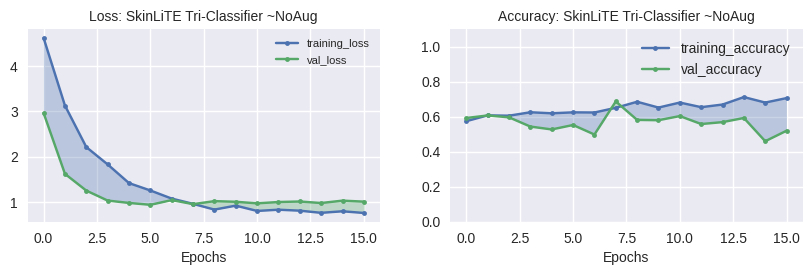

In [ ]:
plot_training_curves(history_SCL_noaug, 'SkinLiTE Tri-Classifier ~NoAug')



---



# 🟣 RandAug


## Experiment 1: Baseline Classifier


In [ ]:
encoder = create_encoder()
classifier = create_classifier(encoder)
history_SL_randaug = run_experiment(randaug_ds, val_ds_v, classifier)

Epoch 1/100
69/69 [==============================] - 239s 711ms/step - loss: 1.5788 - accuracy: 0.3241 - AUC: 0.4972 - Precision: 0.3296 - Recall: 0.4264 - F1 score: 0.2920 - val_loss: 234.5561 - val_accuracy: 0.1364 - val_AUC: 0.5009 - val_Precision: 0.3335 - val_Recall: 0.9964 - val_F1 score: 0.0800 - lr: 0.0010
Epoch 2/100
69/69 [==============================] - 73s 361ms/step - loss: 1.2870 - accuracy: 0.3432 - AUC: 0.5271 - Precision: 0.3532 - Recall: 0.1400 - F1 score: 0.3038 - val_loss: 1.0664 - val_accuracy: 0.4964 - val_AUC: 0.6502 - val_Precision: 0.3651 - val_Recall: 0.1255 - val_F1 score: 0.2739 - lr: 0.0010
Epoch 3/100
69/69 [==============================] - 72s 356ms/step - loss: 1.1906 - accuracy: 0.3095 - AUC: 0.5008 - Precision: 0.3186 - Recall: 0.0491 - F1 score: 0.2843 - val_loss: 1.1571 - val_accuracy: 0.1564 - val_AUC: 0.3635 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1 score: 0.1631 - lr: 0.0010
Epoch 4/100
69/69 [==============================]

<ipython-input-3-ba513de2f957>:8: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn') #ggplot #bmh


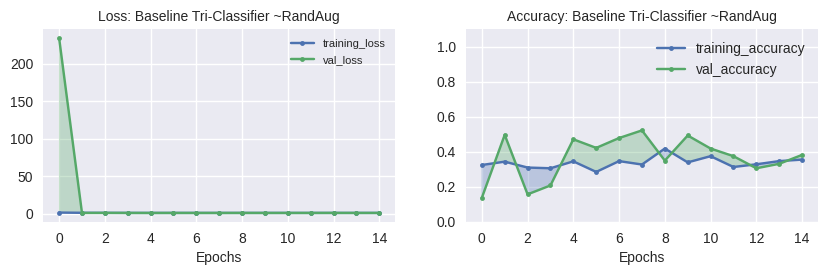

In [ ]:
plot_training_curves(history_SL_randaug, 'Baseline Tri-Classifier ~RandAug')

## Experiment 2: Supervised contrastive learning


In [ ]:
encoder = create_encoder()
encoder_with_projection_head = add_projection_head(encoder)
encoder_with_projection_head.compile(
    optimizer=keras.optimizers.Adam(learning_rate),
    loss=SupervisedContrastiveLoss(temperature),
)
history_SCL_encoder_randaug = encoder_with_projection_head.fit(
    randaug_ds, batch_size=batch_size, epochs=num_epochs
)

Epoch 1/100
69/69 [==============================] - 84s 156ms/step - loss: 3.5142
Epoch 2/100
69/69 [==============================] - 59s 156ms/step - loss: 3.4550
Epoch 3/100
69/69 [==============================] - 59s 157ms/step - loss: 3.4551
Epoch 4/100
69/69 [==============================] - 59s 153ms/step - loss: 3.4545
Epoch 5/100
69/69 [==============================] - 59s 154ms/step - loss: 3.4548
Epoch 6/100
69/69 [==============================] - 59s 156ms/step - loss: 3.4533
Epoch 7/100
69/69 [==============================] - 59s 154ms/step - loss: 3.4548
Epoch 8/100
69/69 [==============================] - 59s 154ms/step - loss: 3.4542
Epoch 9/100
69/69 [==============================] - 59s 153ms/step - loss: 3.4539
Epoch 10/100
69/69 [==============================] - 59s 154ms/step - loss: 3.4537
Epoch 11/100
69/69 [==============================] - 59s 155ms/step - loss: 3.4514
Epoch 12/100
69/69 [==============================] - 59s 155ms/step - loss: 3.4540
E

In [ ]:
classifier = create_classifier(encoder_with_projection_head, trainable=False)
history_SCL_randaug = run_experiment(randaug_ds, val_ds_v, classifier)

Epoch 1/100
69/69 [==============================] - 77s 365ms/step - loss: 15.3709 - accuracy: 0.3150 - AUC: 0.5032 - Precision: 0.3357 - Recall: 0.4559 - F1 score: 0.2802 - val_loss: 6.0070 - val_accuracy: 0.1527 - val_AUC: 0.3776 - val_Precision: 0.1750 - val_Recall: 0.1273 - val_F1 score: 0.1529 - lr: 0.0010
Epoch 2/100
69/69 [==============================] - 71s 335ms/step - loss: 11.1135 - accuracy: 0.3305 - AUC: 0.5065 - Precision: 0.3400 - Recall: 0.4195 - F1 score: 0.2895 - val_loss: 3.6954 - val_accuracy: 0.1927 - val_AUC: 0.4060 - val_Precision: 0.1875 - val_Recall: 0.1255 - val_F1 score: 0.1082 - lr: 0.0010
Epoch 3/100
69/69 [==============================] - 71s 335ms/step - loss: 8.4238 - accuracy: 0.3155 - AUC: 0.4977 - Precision: 0.3300 - Recall: 0.4295 - F1 score: 0.2775 - val_loss: 1.5309 - val_accuracy: 0.2509 - val_AUC: 0.5363 - val_Precision: 0.3420 - val_Recall: 0.6964 - val_F1 score: 0.1871 - lr: 0.0010
Epoch 4/100
69/69 [==============================] - 71s 33

<ipython-input-3-ba513de2f957>:8: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn') #ggplot #bmh


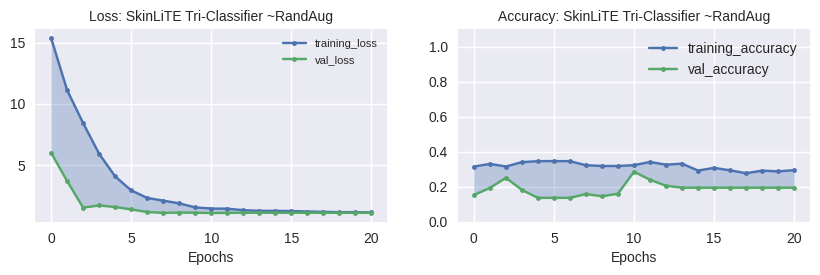

In [ ]:
plot_training_curves(history_SCL_randaug, 'SkinLiTE Tri-Classifier ~RandAug')



---



# 🟣 AugMix


## Experiment 1: Baseline Classifier


In [ ]:
encoder = create_encoder()
classifier = create_classifier(encoder)
history_SL_augmix = run_experiment(augmix_ds, val_ds_v, classifier)

Epoch 1/100
69/69 [==============================] - 131s 1s/step - loss: 1.4783 - accuracy: 0.3286 - AUC: 0.5117 - Precision: 0.3760 - Recall: 0.1536 - F1 score: 0.2978 - val_loss: 96.8371 - val_accuracy: 0.6691 - val_AUC: 0.6041 - val_Precision: 0.4027 - val_Recall: 0.8055 - val_F1 score: 0.2672 - lr: 0.0010
Epoch 2/100
69/69 [==============================] - 123s 1s/step - loss: 1.2634 - accuracy: 0.2932 - AUC: 0.4984 - Precision: 0.3824 - Recall: 0.0732 - F1 score: 0.2833 - val_loss: 4506.6963 - val_accuracy: 0.6655 - val_AUC: 0.6479 - val_Precision: 0.4324 - val_Recall: 0.8600 - val_F1 score: 0.2664 - lr: 0.0010
Epoch 3/100
69/69 [==============================] - 123s 1s/step - loss: 1.1740 - accuracy: 0.3318 - AUC: 0.5162 - Precision: 0.3441 - Recall: 0.0532 - F1 score: 0.3059 - val_loss: 2.4440 - val_accuracy: 0.3273 - val_AUC: 0.5019 - val_Precision: 0.1238 - val_Recall: 0.0236 - val_F1 score: 0.2767 - lr: 0.0010
Epoch 4/100
69/69 [==============================] - 124s 1s/st

<ipython-input-3-ba513de2f957>:8: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn') #ggplot #bmh


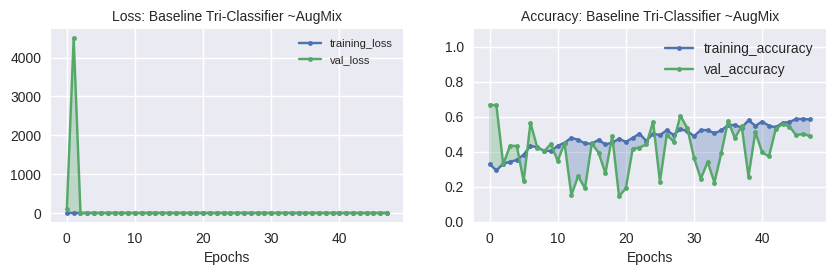

In [ ]:
plot_training_curves(history_SL_augmix, 'Baseline Tri-Classifier ~AugMix')

## Experiment 2: Supervised contrastive learning


In [ ]:
encoder = create_encoder()
encoder_with_projection_head = add_projection_head(encoder)
encoder_with_projection_head.compile(
    optimizer=keras.optimizers.Adam(learning_rate),
    loss=SupervisedContrastiveLoss(temperature),
)
history_SCL_encoder_augmix = encoder_with_projection_head.fit(
    augmix_ds, batch_size=batch_size, epochs=num_epochs
)

Epoch 1/100
69/69 [==============================] - 267s 903ms/step - loss: 3.5053
Epoch 2/100
69/69 [==============================] - 109s 875ms/step - loss: 3.4546
Epoch 3/100
69/69 [==============================] - 109s 881ms/step - loss: 3.4527
Epoch 4/100
69/69 [==============================] - 109s 882ms/step - loss: 3.4521
Epoch 5/100
69/69 [==============================] - 109s 878ms/step - loss: 3.4522
Epoch 6/100
69/69 [==============================] - 109s 887ms/step - loss: 3.4525
Epoch 7/100
69/69 [==============================] - 109s 884ms/step - loss: 3.4511
Epoch 8/100
69/69 [==============================] - 109s 884ms/step - loss: 3.4523
Epoch 9/100
69/69 [==============================] - 109s 884ms/step - loss: 3.4482
Epoch 10/100
69/69 [==============================] - 110s 889ms/step - loss: 3.4466
Epoch 11/100
69/69 [==============================] - 109s 875ms/step - loss: 3.4488
Epoch 12/100
69/69 [==============================] - 110s 888ms/step - lo

In [ ]:
classifier = create_classifier(encoder_with_projection_head, trainable=False)
history_SCL_augmix = run_experiment(augmix_ds, val_ds_v, classifier)

In [ ]:
plot_training_curves(history_SCL_augmix, 'SkinLiTE Tri-Classifier ~AugMix')

# 🟣 MixUp


## Experiment 1: Baseline Classifier


In [ ]:
encoder = create_encoder()
classifier = create_classifier(encoder)
history_SL_mixup = run_experiment(mixup_ds, val_ds_v, classifier)

Epoch 1/100
69/69 [==============================] - 74s 272ms/step - loss: 1.3455 - accuracy: 0.4155 - AUC: 0.5634 - Precision: 0.5738 - Recall: 0.2409 - F1 score: 0.3528 - val_loss: 14984.4336 - val_accuracy: 0.1945 - val_AUC: 0.2482 - val_Precision: 0.1655 - val_Recall: 0.3309 - val_F1 score: 0.1086 - lr: 0.0010
Epoch 2/100
69/69 [==============================] - 66s 254ms/step - loss: 1.1888 - accuracy: 0.4473 - AUC: 0.5879 - Precision: 0.6244 - Recall: 0.1169 - F1 score: 0.3494 - val_loss: 84.6584 - val_accuracy: 0.6691 - val_AUC: 0.6476 - val_Precision: 0.4316 - val_Recall: 0.8600 - val_F1 score: 0.2672 - lr: 0.0010
Epoch 3/100
69/69 [==============================] - 66s 252ms/step - loss: 1.1500 - accuracy: 0.4414 - AUC: 0.5832 - Precision: 0.5780 - Recall: 0.0621 - F1 score: 0.3640 - val_loss: 1.0633 - val_accuracy: 0.3345 - val_AUC: 0.5970 - val_Precision: 0.2013 - val_Recall: 0.0545 - val_F1 score: 0.2458 - lr: 0.0010
Epoch 4/100
69/69 [==============================] - 65s

<ipython-input-3-ba513de2f957>:8: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn') #ggplot #bmh


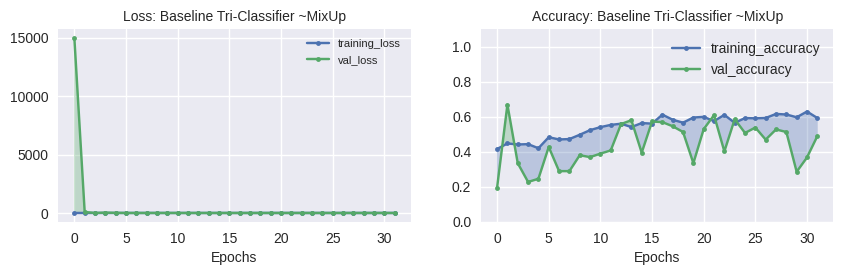

In [ ]:
plot_training_curves(history_SL_mixup, 'Baseline Tri-Classifier ~MixUp')

## Experiment 2: Supervised contrastive learning


In [ ]:
encoder = create_encoder()
encoder_with_projection_head = add_projection_head(encoder)
encoder_with_projection_head.compile(
    optimizer=keras.optimizers.Adam(learning_rate),
    loss=SupervisedContrastiveLoss(temperature),
)
history_SCL_encoder_mixup = encoder_with_projection_head.fit(
    mixup_ds, batch_size=batch_size, epochs=num_epochs
)

Epoch 1/100
69/69 [==============================] - 75s 60ms/step - loss: 3.5059
Epoch 2/100
69/69 [==============================] - 52s 60ms/step - loss: 3.4479
Epoch 3/100
69/69 [==============================] - 53s 60ms/step - loss: 3.4404
Epoch 4/100
69/69 [==============================] - 53s 61ms/step - loss: 3.4410
Epoch 5/100
69/69 [==============================] - 53s 60ms/step - loss: 3.4355
Epoch 6/100
69/69 [==============================] - 53s 60ms/step - loss: 3.4407
Epoch 7/100
69/69 [==============================] - 52s 60ms/step - loss: 3.4352
Epoch 8/100
69/69 [==============================] - 53s 60ms/step - loss: 3.4349
Epoch 9/100
69/69 [==============================] - 53s 60ms/step - loss: 3.4308
Epoch 10/100
69/69 [==============================] - 53s 60ms/step - loss: 3.4267
Epoch 11/100
69/69 [==============================] - 53s 60ms/step - loss: 3.4260
Epoch 12/100
69/69 [==============================] - 52s 60ms/step - loss: 3.4257
Epoch 13/100


In [ ]:
classifier = create_classifier(encoder_with_projection_head, trainable=False)
history_SCL_mixup = run_experiment(mixup_ds, val_ds_v, classifier)

Epoch 1/100
69/69 [==============================] - 69s 246ms/step - loss: 18.2077 - accuracy: 0.3805 - AUC: 0.5178 - Precision: 0.5084 - Recall: 0.5242 - F1 score: 0.3237 - val_loss: 3.0486 - val_accuracy: 0.6636 - val_AUC: 0.7414 - val_Precision: 0.6811 - val_Recall: 0.6018 - val_F1 score: 0.2747 - lr: 0.0010
Epoch 2/100
69/69 [==============================] - 64s 228ms/step - loss: 10.9493 - accuracy: 0.3923 - AUC: 0.5264 - Precision: 0.5155 - Recall: 0.5519 - F1 score: 0.3302 - val_loss: 1.1232 - val_accuracy: 0.2436 - val_AUC: 0.5014 - val_Precision: 0.5000 - val_Recall: 0.0018 - val_F1 score: 0.2083 - lr: 0.0010
Epoch 3/100
69/69 [==============================] - 63s 226ms/step - loss: 6.3633 - accuracy: 0.3905 - AUC: 0.5318 - Precision: 0.5227 - Recall: 0.5240 - F1 score: 0.3389 - val_loss: 0.9665 - val_accuracy: 0.6164 - val_AUC: 0.4995 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1 score: 0.3448 - lr: 0.0010
Epoch 4/100
69/69 [==============================] 

<ipython-input-3-ba513de2f957>:8: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn') #ggplot #bmh


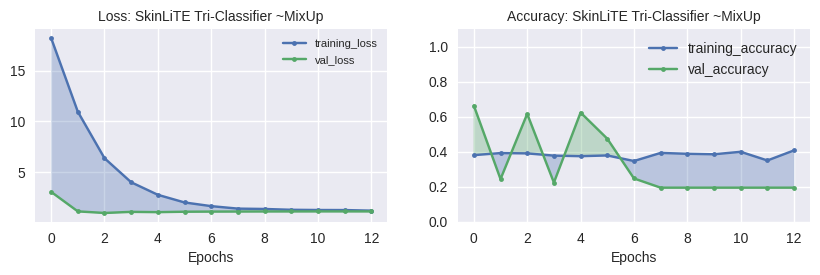

In [ ]:
plot_training_curves(history_SCL_mixup, 'SkinLiTE Tri-Classifier ~MixUp')

# 🟣 CutMix


## Experiment 1: Baseline Classifier


In [ ]:
encoder = create_encoder()
classifier = create_classifier(encoder)
history_SL_cutmix = run_experiment(cutmix_ds, val_ds_v, classifier)

Epoch 1/100
69/69 [==============================] - 325s 1s/step - loss: 1.3030 - accuracy: 0.4686 - AUC: 0.6110 - Precision: 0.6838 - Recall: 0.2066 - F1 score: 0.3565 - val_loss: 445.2026 - val_accuracy: 0.6691 - val_AUC: 0.7427 - val_Precision: 0.6041 - val_Recall: 0.6964 - val_F1 score: 0.2672 - lr: 0.0010
Epoch 2/100
69/69 [==============================] - 66s 255ms/step - loss: 1.1660 - accuracy: 0.5118 - AUC: 0.6631 - Precision: 0.7500 - Recall: 0.1321 - F1 score: 0.3356 - val_loss: 0.9535 - val_accuracy: 0.5982 - val_AUC: 0.6982 - val_Precision: 0.5401 - val_Recall: 0.5018 - val_F1 score: 0.3442 - lr: 0.0010
Epoch 3/100
69/69 [==============================] - 66s 253ms/step - loss: 1.1078 - accuracy: 0.5473 - AUC: 0.6651 - Precision: 0.7305 - Recall: 0.0892 - F1 score: 0.3635 - val_loss: 0.9921 - val_accuracy: 0.6564 - val_AUC: 0.7246 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1 score: 0.3049 - lr: 0.0010
Epoch 4/100
69/69 [==============================] - 

<ipython-input-3-ba513de2f957>:8: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn') #ggplot #bmh


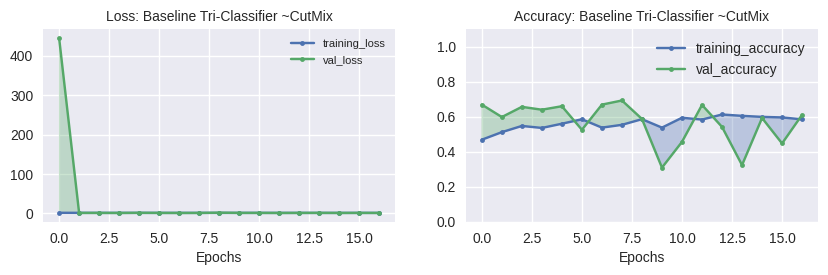

In [ ]:
plot_training_curves(history_SL_cutmix, 'Baseline Tri-Classifier ~CutMix')

## Experiment 2: Supervised contrastive learning


In [ ]:
encoder = create_encoder()
encoder_with_projection_head = add_projection_head(encoder)
encoder_with_projection_head.compile(
    optimizer=keras.optimizers.Adam(learning_rate),
    loss=SupervisedContrastiveLoss(temperature),
)
history_SCL_encoder_cutmix = encoder_with_projection_head.fit(
    cutmix_ds, batch_size=batch_size, epochs=num_epochs
)

Epoch 1/100
69/69 [==============================] - 90s 111ms/step - loss: 3.4933
Epoch 2/100
69/69 [==============================] - 53s 60ms/step - loss: 3.4522
Epoch 3/100
69/69 [==============================] - 52s 60ms/step - loss: 3.4508
Epoch 4/100
69/69 [==============================] - 53s 60ms/step - loss: 3.4513
Epoch 5/100
69/69 [==============================] - 53s 61ms/step - loss: 3.4526
Epoch 6/100
69/69 [==============================] - 52s 59ms/step - loss: 3.4486
Epoch 7/100
69/69 [==============================] - 53s 59ms/step - loss: 3.4501
Epoch 8/100
69/69 [==============================] - 53s 60ms/step - loss: 3.4456
Epoch 9/100
69/69 [==============================] - 53s 61ms/step - loss: 3.4489
Epoch 10/100
69/69 [==============================] - 53s 60ms/step - loss: 3.4470
Epoch 11/100
69/69 [==============================] - 53s 60ms/step - loss: 3.4490
Epoch 12/100
69/69 [==============================] - 53s 60ms/step - loss: 3.4476
Epoch 13/100

In [ ]:
classifier = create_classifier(encoder_with_projection_head, trainable=False)
history_SCL_cutmix = run_experiment(cutmix_ds, val_ds_v, classifier)

Epoch 1/100
69/69 [==============================] - 91s 555ms/step - loss: 18.7721 - accuracy: 0.3673 - AUC: 0.5340 - Precision: 0.5220 - Recall: 0.6005 - F1 score: 0.3185 - val_loss: 4.4283 - val_accuracy: 0.3036 - val_AUC: 0.5573 - val_Precision: 0.3711 - val_Recall: 0.7800 - val_F1 score: 0.2993 - lr: 0.0010
Epoch 2/100
69/69 [==============================] - 67s 251ms/step - loss: 12.7025 - accuracy: 0.3850 - AUC: 0.5406 - Precision: 0.5300 - Recall: 0.5927 - F1 score: 0.3285 - val_loss: 1.8871 - val_accuracy: 0.5018 - val_AUC: 0.6617 - val_Precision: 0.4294 - val_Recall: 0.9182 - val_F1 score: 0.3059 - lr: 0.0010
Epoch 3/100
69/69 [==============================] - 66s 256ms/step - loss: 8.8766 - accuracy: 0.3700 - AUC: 0.5389 - Precision: 0.5258 - Recall: 0.6012 - F1 score: 0.3103 - val_loss: 1.5542 - val_accuracy: 0.5236 - val_AUC: 0.6401 - val_Precision: 0.4050 - val_Recall: 0.8764 - val_F1 score: 0.3871 - lr: 0.0010
Epoch 4/100
69/69 [==============================] - 66s 25

<ipython-input-3-ba513de2f957>:8: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn') #ggplot #bmh


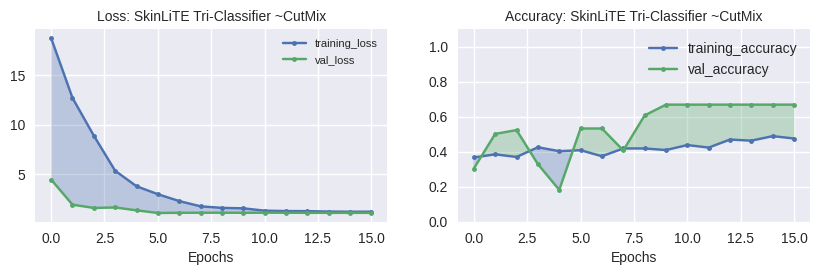

In [ ]:
plot_training_curves(history_SCL_cutmix, 'SkinLiTE Tri-Classifier ~CutMix')